# Logistic Regression


In this notebook implement binary logistic regression from scratch in **`Python`/`Numpy`**. We first generate a two-class dataset. Then derive gradient of the cross-entropy loss. Finally, we implement and test our logistic regression algorithm.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from util import print_result

sns.set()
%matplotlib inline

## Generate a Sample Dataset

First of all, let me generate some syntatic dataset. As you know, logistic regression is a binary classification algorithm. So following code block generates a two-class dataset with two features.

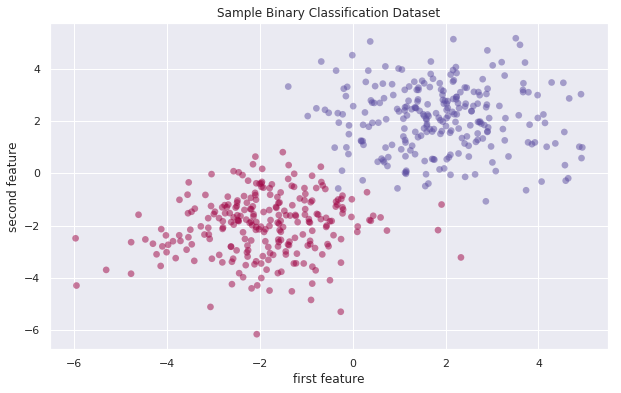

In [2]:
N = 250
np.random.seed(1024)

mean_cls_0 = np.array([-2, -2])
cov_cls_0 = np.array([[1.5, 0], [0, 1.5]])
x0 = np.random.multivariate_normal(mean=mean_cls_0, cov=cov_cls_0, size=N)
y0 = np.zeros(N)

mean_cls_1 = np.array([2, 2])
cov_cls_1 = np.array([[1.5, 0], [0, 1.5]])
x1 = np.random.multivariate_normal(mean=mean_cls_1, cov=cov_cls_1, size=N)
y1 = np.ones(N)

X_train = np.row_stack((x0, x1))
y_train = np.concatenate((y0, y1))

fig = plt.figure(figsize=(10, 6))
axes = plt.axes()
axes.scatter(
    X_train[:, 0],
    X_train[:, 1],
    c=y_train,
    s=45,
    cmap=plt.cm.Spectral,
    alpha=0.5,
    edgecolors='none')
axes.set_xlabel('first feature')
axes.set_ylabel('second feature')
axes.set_title('Sample Binary Classification Dataset')
plt.show()

## Derive Gradient

In logistic regression, we use the sigmoid function to squashe responses between zero and one. Hence, we can writedown following probability values.

$$P(t_n = 1|\mathbf{x_n}, \mathbf{w}) = \frac{1}{1 + e^{-\mathbf{w}^T\mathbf{x}_n}}$$
$$P(t_n = 0|\mathbf{x_n}, \mathbf{w}) = \frac{e^{-\mathbf{w}^T\mathbf{x}_n}}{1 + e^{-\mathbf{w}^T\mathbf{x}_n}}$$

Let $\mathbf{t} = (t_1, t_2, ..., t_N)$ and $\mathbf{X} = (\mathbf{x_1}, \mathbf{x_2}, ..., \mathbf{x_N})$ denote full training dataset and data is coming from a i.i.d. distribution, we can write the folloing likelihood.


$$P(\mathbf{t}|\mathbf{X}, \mathbf{w}) = \prod_{n=1}^{N}\bigg[P(t_n = 1|\mathbf{x_n}, \mathbf{w})^{t_n}P(t_n = 0|\mathbf{x_n}, \mathbf{w})^{(1-t_n)}\bigg]$$

So our objective is find $\mathbf{w}$ in order to maximize above equation. We can further simplfy our optimization task by taking the $log()$ of our likelihood function. Further, $log()$ will not chage the optimum value of $\mathbf{w}$. Also, instead of maximuxing above function, we minimize $-P(\mathbf{t}|\mathbf{X}, \mathbf{w})$. So our new objective function is:

$$-P(\mathbf{t}|\mathbf{X}, \mathbf{w}) = \sum_{n=1}^{N}-\bigg[log(P(t_n = 1|\mathbf{x_n}, \mathbf{w})^{t_n}) + log(P(t_n = 0|\mathbf{x_n}, \mathbf{w})^{(1-t_n)})\bigg]$$
$$-P(\mathbf{t}|\mathbf{X}, \mathbf{w}) = \sum_{n=1}^{N}-\bigg[{t_n}log(P(t_n = 1|\mathbf{x_n}, \mathbf{w})) + (1-t_n)log(P(t_n = 0|\mathbf{x_n}, \mathbf{w}))\bigg]$$

Now let me introduce a new notations:
$$\sigma_n = \frac{1}{1 + e^{-\mathbf{w}^T\mathbf{x}_n}}$$
$$1 - \sigma_n = \frac{e^{-\mathbf{w}^T\mathbf{x}_n}}{1 + e^{-\mathbf{w}^T\mathbf{x}_n}}$$

$$-P(\mathbf{t}|\mathbf{X}, \mathbf{w}) = \sum_{n=1}^{N}-\bigg[{t_n}log(\sigma_n) + (1-t_n)log(1-\sigma_n)\bigg]$$

It is easy to show that $\frac{\partial \sigma_n}{\partial \mathbf{w}} = \sigma_n(1 -\sigma_n)\mathbf{w}$ and $\frac{\partial (1- \sigma_n)}{\partial \mathbf{w}} = -\frac{\partial \sigma_n}{\partial \mathbf{w}}$. By substituting these two equations and taking the derivatives we can show that:

$$\nabla_{\mathbf w}(-P(\mathbf{t}|\mathbf{X}, \mathbf{w})) = \sum_{n=1}^{N}(\sigma_n - t_n)\mathbf{x_n}$$

Now we have everything we need to implement our own Logistic Regression classifier.

## Implementation

In [3]:
class LogisticRegression:
    def __init__(self, learning_rate=1e-3, max_iter=250):
        self.learning_rate = learning_rate
        self.max_iter = max_iter

        self.weights = None

    def fit(self, X_train, y_train):
        X_train = LogisticRegression._fit_intercept(X_train)
        self.weights = np.random.rand(X_train.shape[1])
        for iter in range(self.max_iter):
            self.weights = self.weights - self.learning_rate * LogisticRegression._grad(
                X_train, y_train, self.weights)
            cost = self._cost(X_train, y_train, self.weights)
            print_result(iter, cost)

    def predict(self, X_test, cutoff=0.5):
        X_test = LogisticRegression._fit_intercept(X_test)
        prob = LogisticRegression.sigmoid(np.dot(X_test, self.weights))
        return prob, prob > cutoff

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-1 * x))

    @staticmethod
    def _cost(X_train, y_train, weights):
        cost = 0.0
        for n in range(len(y_train)):
            pos = (y_train[n] * np.log(
                LogisticRegression.sigmoid(np.inner(X_train[n, :], weights))))
            neg = ((1 - y_train[n]) * np.log(1 - LogisticRegression.sigmoid(
                np.inner(X_train[n, :], weights))))
            cct_cost = -1 * (pos + neg)
            cost += cct_cost / X_train.shape[0]
        return cost

    @staticmethod
    def _grad(X_train, y_train, weights):
        grad = np.zeros(X_train.shape[1])
        for n in range(len(y_train)):
            grad += (LogisticRegression.sigmoid(
                np.inner(X_train[n, :], weights)) - y_train[n]) * X_train[n, :]
        return grad

    @staticmethod
    def _fit_intercept(X_train):
        """Add the intercepting term to the training dataset

        This simple helper method adds the intercepting term to the 
        training dataset.

        Arguments:
            X_train: training dataset

        Returns: training dataset with the interceptor
        """
        return np.column_stack((np.ones(X_train.shape[0]), X_train))

 Now the Logistic Regression algorithm is ready. Let's train it using our synthetic 2-D dataset and plot the result.

iteration:          0		cost: 1.7632e-01
iteration:          1		cost: 1.4222e-01
iteration:          2		cost: 1.2186e-01
iteration:          3		cost: 1.0802e-01
iteration:          4		cost: 9.7859e-02
iteration:          5		cost: 9.0015e-02
iteration:          6		cost: 8.3737e-02
iteration:          7		cost: 7.8576e-02
iteration:          8		cost: 7.4243e-02
iteration:          9		cost: 7.0543e-02
iteration:         10		cost: 6.7340e-02
iteration:         20		cost: 4.9149e-02
iteration:         30		cost: 4.0958e-02
iteration:         40		cost: 3.6193e-02
iteration:         50		cost: 3.3043e-02
iteration:         60		cost: 3.0791e-02
iteration:         70		cost: 2.9092e-02
iteration:         80		cost: 2.7760e-02
iteration:         90		cost: 2.6685e-02
iteration:        100		cost: 2.5796e-02
iteration:        200		cost: 2.1366e-02
iteration:        300		cost: 1.9642e-02
iteration:        400		cost: 1.8699e-02


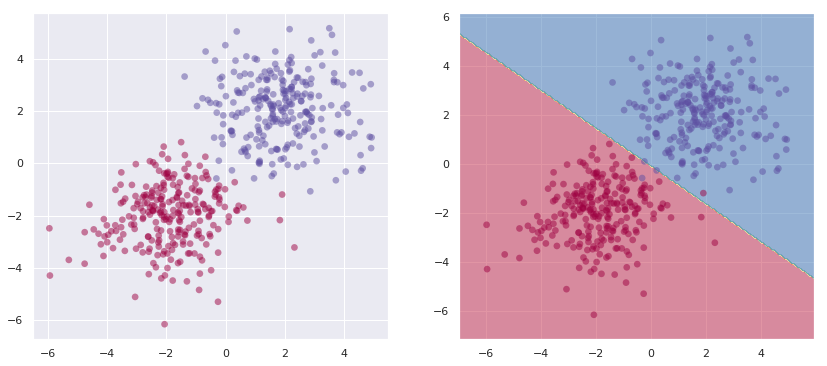

In [4]:
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

x0_features = np.arange(X_train[:, 0].min() - 1, X_train[:, 0].max() + 1, 0.05)
x1_features = np.arange(X_train[:, 1].min() - 1, X_train[:, 1].max() + 1, 0.05)

x0_features, x1_features = np.meshgrid(x0_features, x1_features)

_, y_pred = model.predict(
    np.column_stack((x0_features.flatten(), x1_features.flatten())))
y_pred = y_pred.reshape(x0_features.shape)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.scatter(
    X_train[:, 0],
    X_train[:, 1],
    c=y_train,
    s=45,
    cmap=plt.cm.Spectral,
    alpha=0.5,
    edgecolors='none')

ax2.contourf(x0_features, x1_features, y_pred, alpha=0.5, cmap=plt.cm.Spectral)
ax2.scatter(
    X_train[:, 0],
    X_train[:, 1],
    c=y_train,
    s=45,
    cmap=plt.cm.Spectral,
    alpha=0.5,
    edgecolors='none')

plt.show()

## Summary

In this notebook, we implemented Logistic Regression from scratch using Python/Numpy.  We used maximum likelihood estimator for estimating the parameter of the model. 

Actually, we can look at Logistic Regression Baysean perspective as well. Later we will show you how we can do that from scratch :-).

## References and Further Reading

1. https://www.youtube.com/watch?v=mz3j59aJBZQ [Readdy good introduction to Logistic Regression by Nando de Freitas] 

2. Pattern Recognition and Machine Learning, Christopher Bishop, https://www.amazon.com/Pattern-Recognition-Learning-Information-Statistics/dp/0387310738 